# Forecasting Temperatures
* Predicting the next day's temperature

## Summary:
**Dataset:** Daily temperature values and calendar dates over a ten year period  
**Model:** Recurrent Neural Network which outputs the temperature value for the following day  
**Particulars:** Time series cross-validation splits, sliding window with time lags, neural network with recurrent nodes (LSTM and GRU)

## Table of Contents:
* Section 1 - Data Exploration
* Section 2 - Data Preparation and Preprocessing
* Section 3 - Time Series Cross-Validation Splits
* Section 4 - Model and Hyperparameter Tuning
* Section 5 - Final Model and Results

In [2]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from scikeras.wrappers import KerasRegressor

In [3]:
print("Python version:", platform.python_version())

Python version: 3.10.12


In [4]:
pd.options.display.max_columns = None

# Section 1 - Data Exploration

In [5]:
# Importing data, containing daily temperature values and dates
df_init = pd.read_csv("temperatures.csv")

In [6]:
# Exploring dataset contents

display(df_init.head(3))
print(
    f"""

Dates range: {min(df_init['Date'])} to {max(df_init['Date'])}

"""
)
display(df_init.describe())
print("\n")
display(df_init.info())

,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5




Dates range: 1981-01-01 to 1990-12-31




,Temperature
count,3650.000000
mean,20.009151
std,6.108353
min,7.000000
25%,15.400000
50%,18.900000
75%,23.000000
max,43.300000




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3650 non-null   object 
 1   Temperature  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


None

# Section 2 - Data Preparation and Preprocessing

In [7]:
# Preparing data for use in the model

# Converting dates to datetime format and setting them as the index
df_temps = df_init.copy()
df_temps["Date"] = pd.to_datetime(df_temps["Date"])
df_temps = df_temps.set_index("Date")

# Scaling temperature values
scaler = MinMaxScaler()
df_temps["Scaled_Temperature"] = scaler.fit_transform(df_temps)

# Generating time lags for each temperature data point
no_of_lags = 25

for lag in range(1, no_of_lags + 1):
    df_temps[f"lag_{lag}"] = df_temps["Scaled_Temperature"].shift(lag)

display(df_temps.head(3))

,Temperature,Scaled_Temperature,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-01-01,38.1,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,32.4,0.699725,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,34.5,0.757576,0.699725,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Finalizing the data preparation into the time series inputs and response variables

# Reversing column order in order to forward feed into the recurrent nodes, and dropping rows missing
df_data = df_temps.iloc[:, ::-1].copy()

# Dropping rows with NaN (incomplete sequences) and separating features from response variables
df_data = df_data.dropna()
X = df_data.drop(["Temperature", "Scaled_Temperature"], axis=1)
y = df_data[["Scaled_Temperature"]]

print(
    f"""
Temperature points: {df_temps.shape[0]}
Time series data points: {X.shape[0]}
"""
)


Temperature points: 3650
Time series data points: 3625



In [9]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False, random_state=1
)

# Section 3 - Time Series Cross-Validation Splits

In [10]:
# Initializing a TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5)

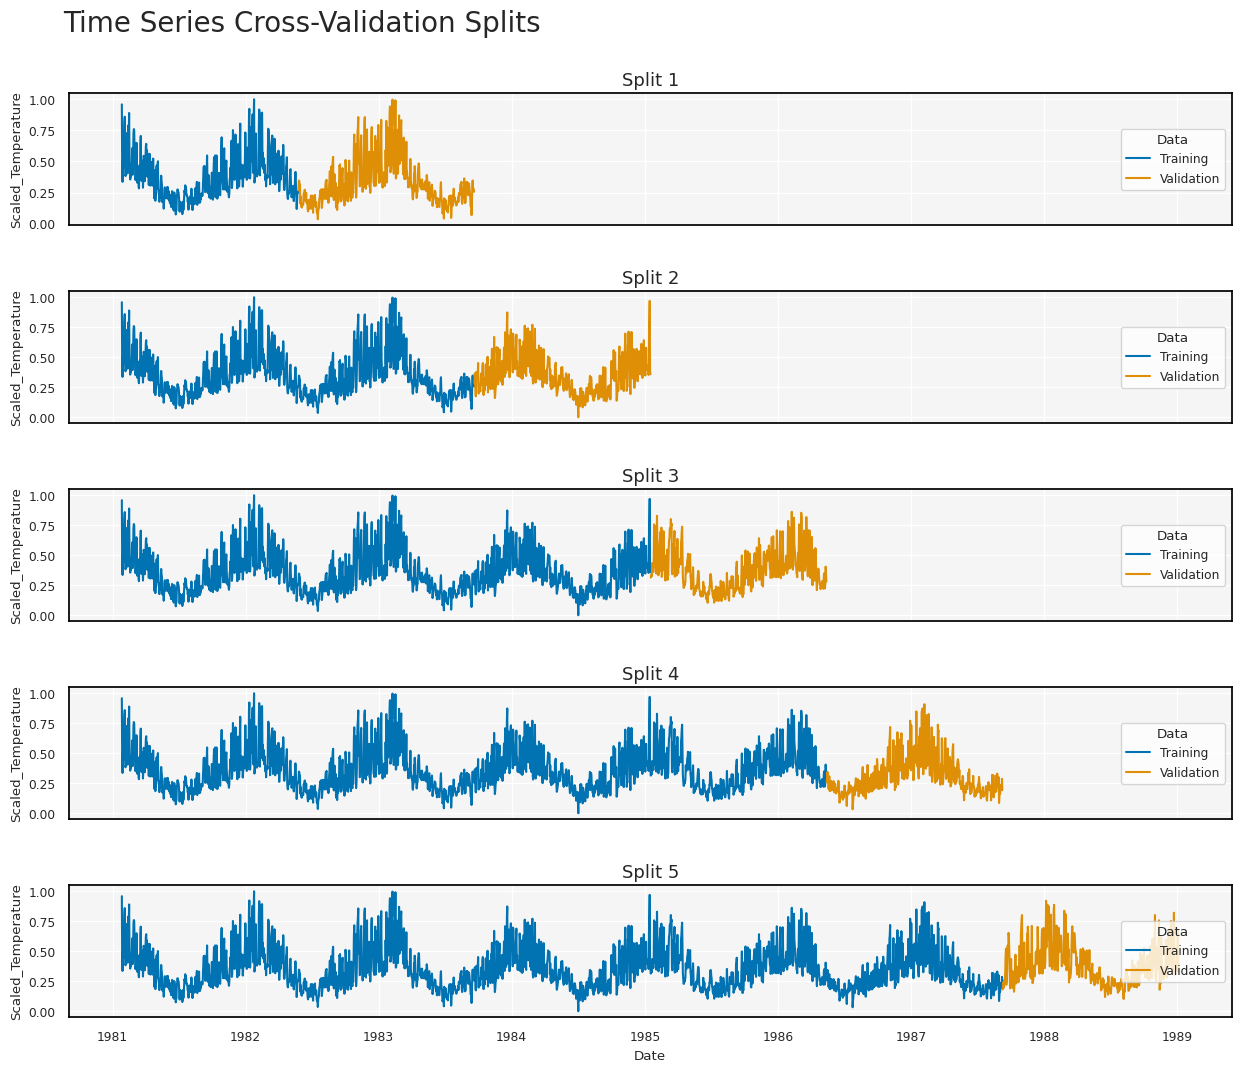

In [11]:
# Visually plotting the sequential training and validation splits for time series cross-validation

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=0.8
)

fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

for i, ((train_subset_index, validation_index), ax) in enumerate(
    zip(tss.split(X_train), axs.ravel())
):
    X_train_subset, X_validation = (
        X.iloc[train_subset_index].copy(),
        X.iloc[validation_index].copy(),
    )
    y_train_subset, y_validation = (
        y.iloc[train_subset_index].copy(),
        y.iloc[validation_index].copy(),
    )

    y_train_subset["label"] = "Training"
    y_validation["label"] = "Validation"

    y_concat = pd.concat([y_train_subset, y_validation], axis=0)

    sns.lineplot(
        x="Date",
        y="Scaled_Temperature",
        data=y_concat,
        hue="label",
        palette="colorblind",
        ax=ax,
    )
    ax.set_title(f"Split {i+1}", fontsize=13)
    ax.legend(facecolor="white", loc="center right").set_title("Data")

plt.subplots_adjust(wspace=0.05, hspace=0.5)
fig.suptitle("Time Series Cross-Validation Splits", x=0.28, y=0.95, fontsize=20);

# Section 4 - Model and Hyperparameter Tuning

In [12]:
# Containing neural network architecture within a function for reproducibility and for use in wrapper (see below)

def create_model_function(nodes_type: str, nodes_no_1: int, nodes_no_2: int):
    """
    Fully connected neural network consists of:
    an embedding layer, two recurrent layers, and two dense layers,
    with a softmax output displaying the predicted probability of each origin

    """

    K.clear_session()
    tf.random.set_seed(0)

    recurrent_node = getattr(tf.keras.layers, nodes_type)

    model = Sequential(
        [
            recurrent_node(nodes_no_1, return_sequences=True, input_shape=[None, 1]),
            recurrent_node(nodes_no_2),
            Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["RootMeanSquaredError"])

    return model

In [13]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df = pd.DataFrame()

# Initializing variables which will also be used for final model
EPOCHS_NO = 20
BATCH_SIZE_NO = None

# Outlining the hyperparameters to try
node_type_list = ["LSTM", "GRU"]

search_space = {
    "nodes_no_1": Integer(10, 150),
    "nodes_no_2": Integer(10, 150),
}

# Running scores twice to compare results using LSTM vs. GRU nodes
for node_type in node_type_list:
    # Wrapper needed to use BayesSearchCV on Tensorflow model
    wrapper_model = KerasRegressor(
        model=create_model_function,
        nodes_type=node_type,
        nodes_no_1=50,
        nodes_no_2=50,
    )

    BSCV_timeseries = BayesSearchCV(
        wrapper_model,
        search_space,
        n_iter=9,
        cv=tss.split(X_train),
        scoring="neg_root_mean_squared_error",
        random_state=1,
    )

    BSCV_timeseries.fit(
        X_train, y_train, epochs=EPOCHS_NO, batch_size=BATCH_SIZE_NO, verbose=0
    )

    # Combining the results tables using the diffrent types of recurrent nodes
    results_df = pd.concat(
        [
            results_df,
            pd.DataFrame(BSCV_timeseries.cv_results_).assign(
                param_nodes_type=node_type
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df = results_df.sort_values("mean_test_score", ascending=False).reset_index()

# Storing the best hyperparameter values
best_params = results_df.iloc[0]["params"]
best_nodes_type = results_df.iloc[0]["param_nodes_type"]

display(results_df[0:3])

16/16 [==============================] - 1s 3ms/step


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nodes_no_1,param_nodes_no_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_nodes_type
0,2,9.920349,1.408960,0.692167,0.061540,126,12,"{'nodes_no_1': 126, 'nodes_no_2': 12}",-0.112759,-0.109722,-0.105911,-0.104646,-0.109702,-0.108548,0.002920,1,GRU
1,0,9.864588,2.305375,0.799915,0.178969,108,19,"{'nodes_no_1': 108, 'nodes_no_2': 19}",-0.113518,-0.110064,-0.106134,-0.104485,-0.109638,-0.108768,0.003171,2,GRU
2,6,10.009475,3.327249,0.820296,0.218293,101,24,"{'nodes_no_1': 101, 'nodes_no_2': 24}",-0.112968,-0.110279,-0.106082,-0.104769,-0.109776,-0.108775,0.002971,3,GRU


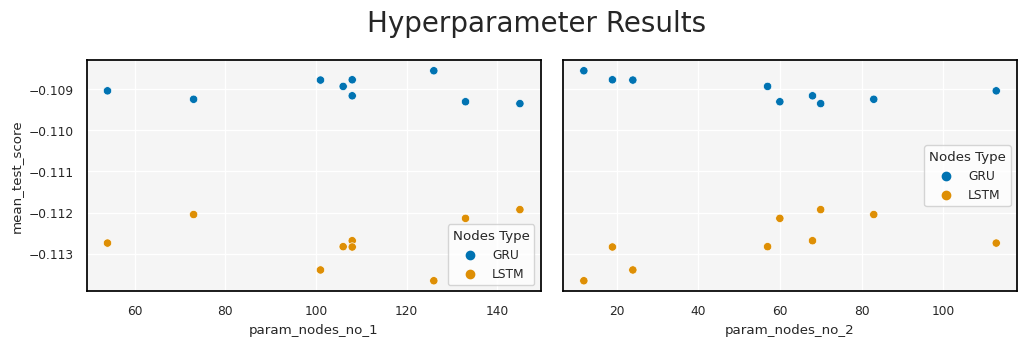

In [14]:
# Plotting the results for different hyperparameters

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=0.8
)

fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space, axs.ravel())):
    sns.scatterplot(
        data=results_df,
        x="param_" + param_category,
        y="mean_test_score",
        hue="param_nodes_type",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white").set_title("Nodes Type")

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Hyperparameter Results", y=1.05, fontsize=20);

# Section 5 - Final Model and Results

In [15]:
# Generating the final model using the best hyperparameters

final_model = create_model_function(best_nodes_type, **best_params)

h = final_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS_NO,
    batch_size=BATCH_SIZE_NO,
    validation_data=(X_test, y_test),
    verbose=0,
)

final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 126)         48762     
                                                                 
 gru_1 (GRU)                 (None, 12)                5040      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 53815 (210.21 KB)
Trainable params: 53815 (210.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Generating the model predictions for the test set and reversing the scaling applied on temperature values

y_pred = final_model.predict(X_test)

temps_pred = scaler.inverse_transform(y_pred)
temps_pred_df = pd.DataFrame(temps_pred, columns=["Temperature"], index=y_test.index)

temps_actual = scaler.inverse_transform(y_test)
temps_actual_df = pd.DataFrame(temps_actual, columns=["Temperature"], index=y_test.index)

23/23 [==============================] - 1s 4ms/step


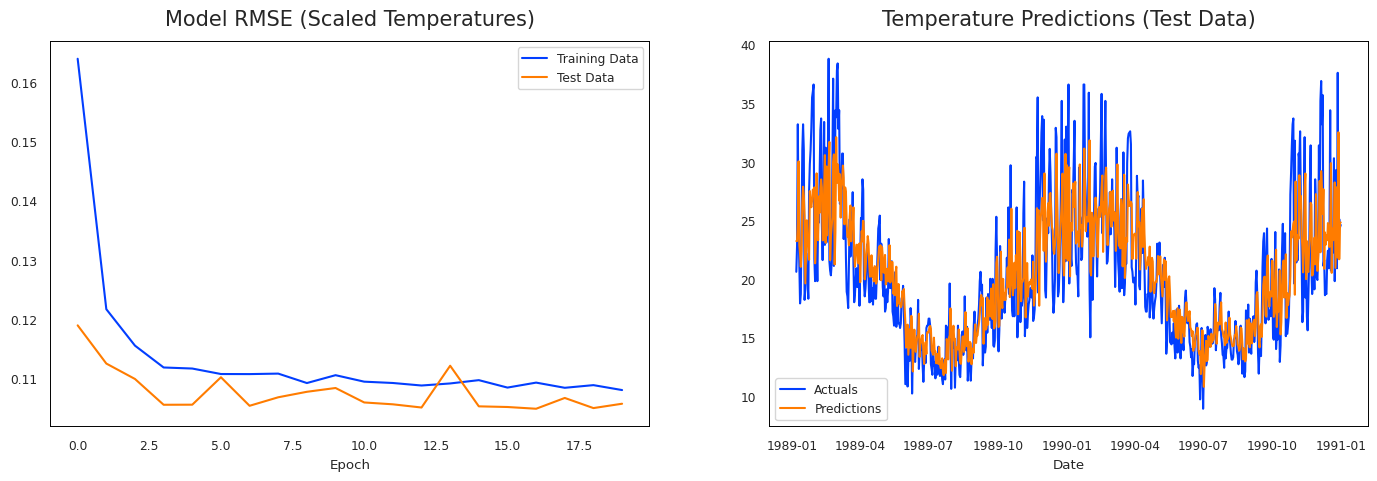

In [17]:
# Plotting the model RMSE loss for each epoch during training and plotting test data predicions

sns.set_theme(
    rc={
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.7,
    },
    font_scale=0.8,
)

sns.set_palette("bright")

fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(h.history["root_mean_squared_error"], label="Training Data")
ax[0].plot(h.history["val_root_mean_squared_error"], label="Test Data")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Model RMSE (Scaled Temperatures)", y=1.02, fontsize=15)
ax[0].legend()

ax[1].plot(temps_actual_df, label="Actuals")
ax[1].plot(temps_pred_df, label="Predictions")
ax[1].set_xlabel("Date")
ax[1].set_title("Temperature Predictions (Test Data)", y=1.02, fontsize=15)
ax[1].legend();

In [18]:
# Comparing the RMSE of the model (w unscaled values) to the RMSE of simply using the previous day's temperature as the prediction

# Generating a one day time lag of the actual temperature values
temps_df = temps_actual_df.copy()
temps_df[f"lag_{1}"] = temps_df["Temperature"].shift(1)
temps_df = temps_df.dropna()

# Calculating the RMSE values
lag_rmse = sqrt(((temps_df["Temperature"] - temps_df["lag_1"]) ** 2).mean())
model_rmse = sqrt(
    ((temps_pred_df["Temperature"] - temps_actual_df["Temperature"]) ** 2).mean()
)

print(
    f"""
Temperature RMSE Using Model Predictions: {model_rmse:0.2f}
Temperature RMSE Using Previous Day's Value: {lag_rmse:0.2f}
"""
)


Temperature RMSE Using Model Predictions: 3.84
Temperature RMSE Using Previous Day's Value: 4.34

